In [139]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import PIL.Image as Image
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pickle 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [140]:
def create_embedding_resnet():
    resnet50_base = models.resnet50(weights='DEFAULT')
    resnet50_embed = torch.nn.Sequential(*(list(resnet50_base.children())[:-1]))
    return resnet50_embed

labels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
label_mapping = {
    0:'daisy',
    1:'dandelion',
    2:'rose',
    3:'sunflower',
    4:'tulip'
}
inv_label_mapping = {
    'daisy':0,
    'dandelion':1,
    'rose':2,
    'sunflower':3,
    'tulip':4
}

def preprocess_single_image(img_tensor):
    img = img_tensor
    img = img / 255.0
    #preprocess for resnet
    img = transforms.Resize((224,224))(img)
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
    img = transforms.CenterCrop(224)(img)
    return img


In [141]:

dataset_path = os.getcwd() + '\\flowers\\train'

flowers = []
labels = []

for i in range(5):
    with os.scandir(dataset_path + '\\' + label_mapping[i]) as entries:
        for entry in entries:
            if entry.name.endswith('.jpg'):
                flowers.append(entry.path)
                labels.append(i)
            else:
                raise Exception("non jpg file found in dataset")
            
def get_flattened_image(file):
    img = Image.open(file)
    img = torch.tensor(np.array(img)).permute(2,0,1).unsqueeze(0).float().to(device)
    img = preprocess_single_image(img)
    img = transforms.Resize((100,100))(img)
    img = img.view(1, -1)
    return img

def get_feature_representation(file, model):

    with torch.no_grad():
        #load image into PIL
        img = Image.open(file)

        img = torch.tensor(np.array(img)).permute(2,0,1).unsqueeze(0).float().to(device)
        
        img = preprocess_single_image(img)
        
        features = model(img)
        return features

data_model = {}
data_vanilla = {}

resnet50_embed = create_embedding_resnet().to(device)
resnet50_embed.eval()

model_embedding_file = 'model_embedding.pkl'
vanilla_embedding_file = 'vanilla_embedding.pkl'
if(os.path.exists(model_embedding_file) and os.path.exists(vanilla_embedding_file)):
    with open(model_embedding_file, 'rb') as model_embedding_file:
        data_model = pickle.load(model_embedding_file)
    print("loaded data from model embedding file")
    with open(vanilla_embedding_file, 'rb') as vanilla_embedding_file:
        data_vanilla = pickle.load(vanilla_embedding_file)
    print("loaded data from vanilla embedding file")

else:
    for flower in tqdm(flowers):
        data_model[flower] = get_feature_representation(flower, resnet50_embed)
        data_vanilla[flower] = get_flattened_image(flower)

    with open(model_embedding_file, 'wb') as f:
        pickle.dump(data_model, f)
        print("saved model embedding to file")
    with open(vanilla_embedding_file, 'wb') as f:
        pickle.dump(data_vanilla, f)
        print("saved vanilla embedding to file")
    

filenames = np.array(list(data_model.keys()))
features_model = np.array([data_model[flower].cpu().detach().numpy() for flower in filenames])

labels = np.array(labels)
features_model = features_model.reshape(features_model.shape[0], -1)

features_vanilla = np.array([data_vanilla[flower].cpu().detach().numpy() for flower in filenames])
features_vanilla = features_vanilla.reshape(features_vanilla.shape[0], -1)



loaded data from model embedding file
loaded data from vanilla embedding file


In [147]:
#code for PCA of the data

pca100_model = PCA(n_components=100, random_state=24)
pca100_model.fit(features_model)
reduced_model_features = pca100_model.transform(features_model)

print(reduced_model_features.shape)

(2746, 100)


In [143]:
kmeans_model = KMeans(n_clusters=5, random_state=10)
kmeans_model.fit(reduced_model_features)


KMeans(n_clusters=5, random_state=10)

In [150]:
groups = {}
for file, cluster in zip(filenames,kmeans_model.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

def get_class_from_filename(filename):
    return filename.split('\\')[-2]

from collections import Counter
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    files = groups[cluster]
    name_counts = Counter([get_class_from_filename(file) for file in files])
    maxname = max(name_counts, key=name_counts.get) 
    files = [file for file in files if get_class_from_filename(file) == maxname]
    if len(files) > 30:
        files = files[:30]   
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = Image.open(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')



Some cluster outputs


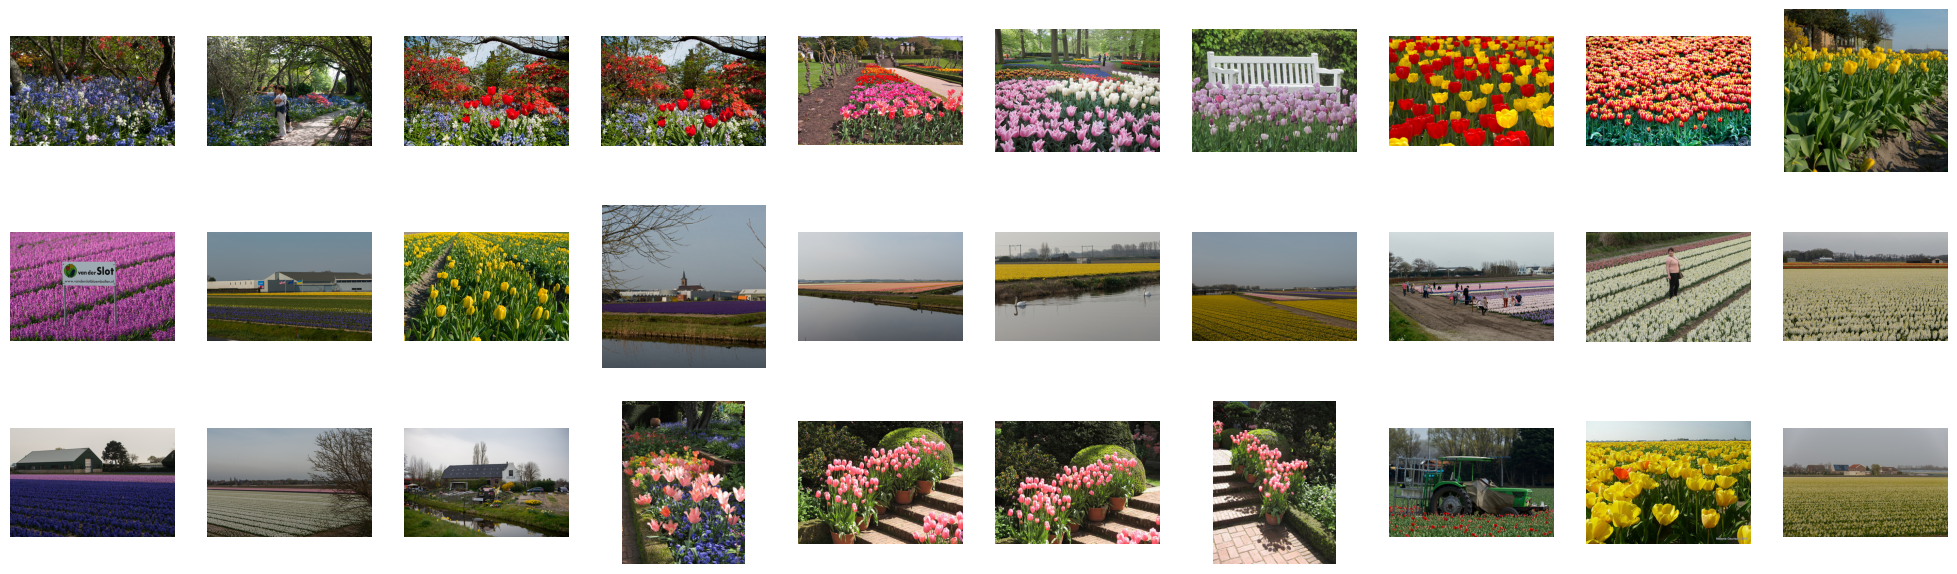

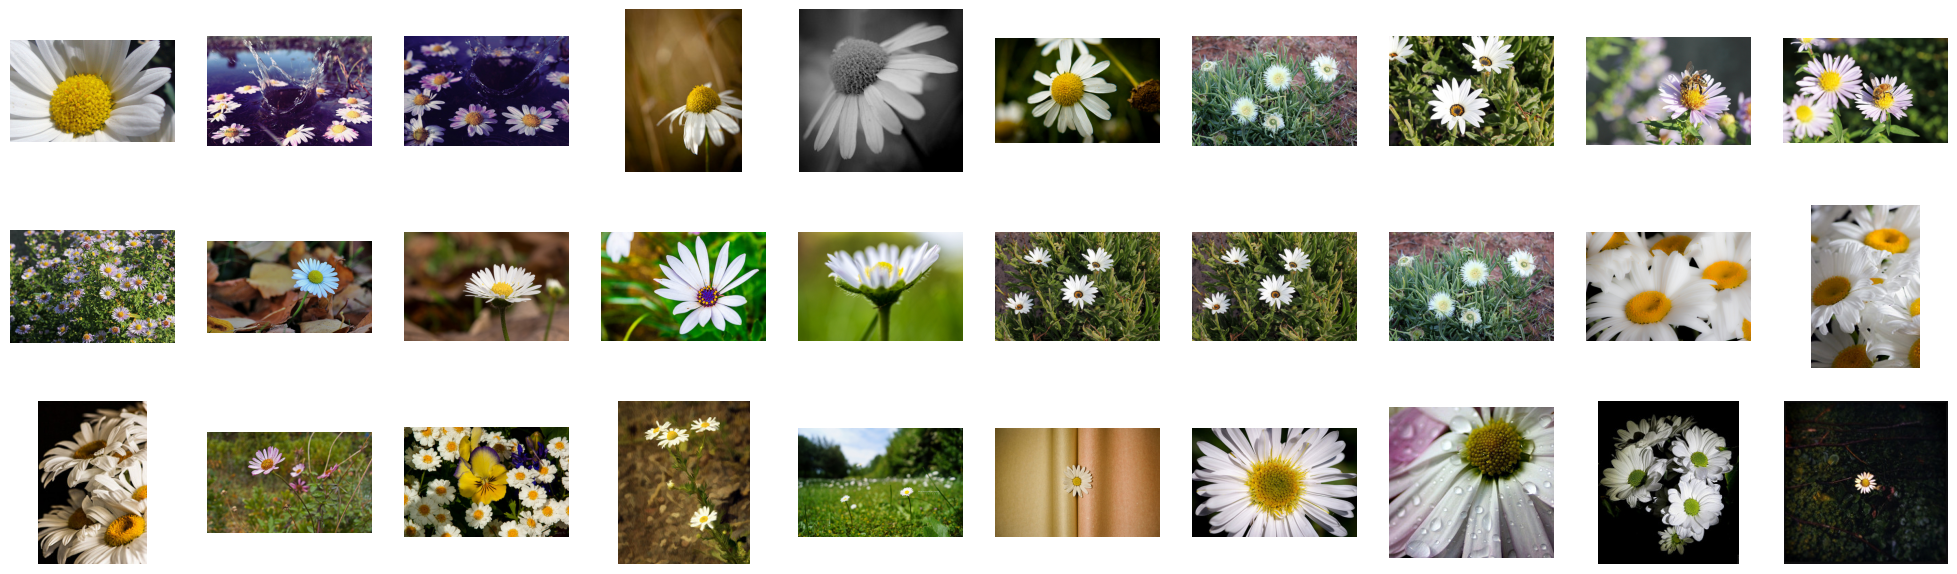

In [151]:
print('Some cluster outputs')
view_cluster(0)
plt.show()

print("=====================================================")

view_cluster(1)
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

model inertia calculated as 65511.2109375


 17%|█▋        | 1/6 [00:04<00:24,  4.91s/it]

vanilla inertia calculated as 35105636.0
model inertia calculated as 108205.1171875


 33%|███▎      | 2/6 [00:11<00:23,  5.84s/it]

vanilla inertia calculated as 47669244.0
model inertia calculated as 138085.640625


 50%|█████     | 3/6 [00:15<00:15,  5.21s/it]

vanilla inertia calculated as 55730072.0
model inertia calculated as 173056.90625


 67%|██████▋   | 4/6 [00:22<00:11,  5.84s/it]

vanilla inertia calculated as 63192140.0
model inertia calculated as 186304.765625


 83%|████████▎ | 5/6 [00:31<00:06,  6.80s/it]

vanilla inertia calculated as 67309536.0
model inertia calculated as 218430.515625


100%|██████████| 6/6 [00:44<00:00,  7.43s/it]

vanilla inertia calculated as 73810104.0
[6551.12109375, 4328.2046875, 2761.7128125, 1730.5690625, 1242.0317708333334, 728.10171875]
[3510563.6, 1906769.76, 1114601.44, 631921.4, 448730.24, 246033.68]


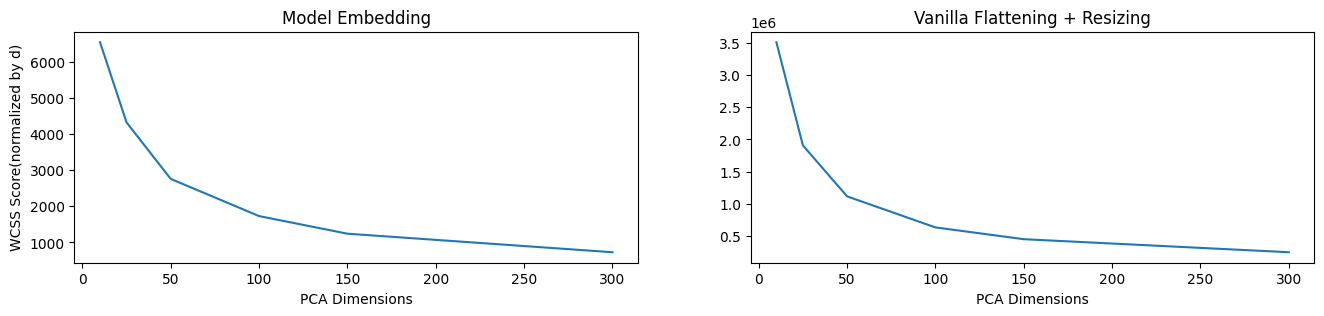

In [154]:
#now we will take the impact of PCA dimensions on WCSS score 

pca_dims = [10, 25, 50, 100, 150, 300]

wcss_model = []
wcss_vanilla = []

kmeans_model = KMeans(n_clusters=5, random_state=10)
kmeans_vanilla = KMeans(n_clusters=5, random_state=10)

for dim in tqdm(pca_dims):

    pca_model = PCA(n_components=dim, random_state=24)
    pca_model.fit(features_model)
    # print(f"model pca fitted for {dim} dimensions")
    reduced_model_features = pca_model.transform(features_model)
    # print(f"model pca transformed for {dim} dimensions")
    kmeans_model.fit(reduced_model_features)
    # print(f"model kmeans fitted for {dim} dimensions")
    wcss_model.append(kmeans_model.inertia_/dim)
    print(f"model inertia calculated as {kmeans_model.inertia_}")

    pca_vanilla = PCA(n_components=dim, random_state=24)
    # print(features_vanilla.shape)
    pca_vanilla.fit(features_vanilla)
    # print(f"vanilla pca fitted for {dim} dimensions")
    reduced_vanilla_features = pca_vanilla.transform(features_vanilla)
    # print(f"vanilla pca transformed for {dim} dimensions")
    kmeans_vanilla.fit(reduced_vanilla_features)
    # print(f"vanilla kmeans fitted for {dim} dimensions")
    wcss_vanilla.append(kmeans_vanilla.inertia_/dim)
    print(f"vanilla inertia calculated as {kmeans_vanilla.inertia_}")

print(wcss_model)
print(wcss_vanilla)


#plot wcss score in different plots 
plt.figure(figsize=(16,3))
ax1 = plt.subplot(121)
ax1.plot(pca_dims, wcss_model)
ax1.set_title('Model Embedding')
ax1.set_xlabel('PCA Dimensions')
ax1.set_ylabel('WCSS Score(normalized by d)')

ax2 = plt.subplot(122)
ax2.plot(pca_dims, wcss_vanilla)
ax2.set_title('Vanilla Flattening + Resizing')
ax2.set_xlabel('PCA Dimensions')


plt.show()



